# JulES as a medium-term prognosis model

### Import packages

In [1]:
using Pkg; Pkg.status()
Pkg.add("CSV"); Pkg.add("Revise"); Pkg.add("Plots"); Pkg.add("PlotlyJS"); Pkg.add("PrettyTables")
# Pkg.update("TuLiPa") # uncomment to update TuLiPa to latest version
# Pkg.develop(path=joinpath(dirname(dirname(pwd())),"TuLiPa")); Pkg.status() # go to development version
# Pkg.undo(); Pkg.status() # go back to main package version
#Pkg.add(url="https://github.com/NVE/TuLiPa.git", rev="redesign_JulES"); Pkg.status() # alternative go back to latest version

Project JulES v0.1.0
Status `X:\Prosjekter\2022_FoU_markedsmodell_julia\Brukere\mary\JulES\Project.toml`
  [336ed68f] CSV v0.10.14
  [aaaa29a8] Clustering v0.15.7
  [a93c6f00] DataFrames v1.6.1
  [aaf54ef3] DistributedArrays v0.6.7
⌃ [31c24e10] Distributions v0.25.107
  [7073ff75] IJulia v1.24.2
  [682c06a0] JSON v0.21.4
  [f0f68f2c] PlotlyJS v0.18.13
  [91a5bcdd] Plots v1.40.4
⌃ [aea7be01] PrecompileTools v1.2.0
  [08abe8d2] PrettyTables v2.3.2
  [295af30f] Revise v3.5.14
  [970f5c25] TuLiPa v0.1.0 `https://github.com/NVE/TuLiPa.git#redesign_JulES`
⌃ [ddb6d928] YAML v0.4.9
  [ade2ca70] Dates
  [8ba89e20] Distributed
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [2]:
using DataFrames, Statistics, JSON, Distributed, Clustering, YAML, Distributions, Revise, Plots, PrettyTables, Random
plotlyjs(); # uncomment for interactive plots

WebIO._IJuliaInit()

In [32]:
# config = YAML.load_file(joinpath("data", "config_jules_prognose.yml")) # config without datasets
config = YAML.load_file(joinpath("data", "config_jules_prognose_demo.yml")) # config with NVE datasets
config = YAML.load_file(joinpath(dirname(dirname(pwd())), "JulESIO", "config_jules_la_demo.yml")) # config with NVE datasets
weatheryear = config["main"]["weatheryears"][1]
datayear = config["main"]["datayears"][1]

2024

### Prepare parallell processing - import code on all cores

In [33]:
const numcores = config["main"]["numcores"]

if nprocs() < numcores
    addprocs(numcores - nprocs())
end

@show nprocs();

nprocs() = 5


In [5]:
@everywhere using TuLiPa, Dates
# @everywhere include(joinpath(dirname(dirname(pwd())),"TuLiPa/src/TuLiPa.jl"));

In [34]:
@everywhere using JulES

In [35]:
function getdataset(config, weatheryear)
    settings = config[config["main"]["settings"]]

    sti_dataset = joinpath(config["main"]["inputpath"], "static_input")
    weekstart = config["main"]["weekstart"]

    sti_dataset1 = joinpath(config["main"]["inputpath"], "Uke_$weekstart", "input")

    exd = JSON.parsefile(joinpath(sti_dataset1, "exogenprices_prognose1.json"))
    exogen = JulES.getelements(exd, sti_dataset1)

    add = JSON.parsefile(joinpath(sti_dataset, "aggdetd2.json"))
    aggdetd = JulES.getelements(add, sti_dataset)

    ipad = JSON.parsefile(joinpath(sti_dataset1, "tilsigsprognoseragg$weatheryear.json"))
    agginflow = JulES.getelements(ipad, sti_dataset1)

    thd = JSON.parsefile(joinpath(sti_dataset, "termisk1.json"))
    thermal = JulES.getelements(thd, sti_dataset)

    wsd = JSON.parsefile(joinpath(sti_dataset, "vindsol.json"))
    windsol = JulES.getelements(wsd, sti_dataset)

    trd = JSON.parsefile(joinpath(sti_dataset1, "nett.json"))
    transm = JulES.getelements(trd)

    cod = JSON.parsefile(joinpath(sti_dataset, "forbruk5.json"))
    cons = JulES.getelements(cod, sti_dataset)

    fpd = JSON.parsefile(joinpath(sti_dataset1, "brenselspriser.json"))
    fuel = JulES.getelements(fpd, sti_dataset1)

    nud = JSON.parsefile(joinpath(sti_dataset1, "nuclear.json"))
    nuclear = JulES.getelements(nud, sti_dataset1)

    dse = JSON.parsefile(joinpath(sti_dataset, "tidsserier_detd.json"))
    detdseries = JulES.getelements(dse, sti_dataset)

    dda = JSON.parsefile(joinpath(sti_dataset, "dataset_detd.json"))
    detdstructure = JulES.getelements(dda)

    ipd = JSON.parsefile(joinpath(sti_dataset1, "tilsigsprognoser$weatheryear.json"))
    inflow = JulES.getelements(ipd, sti_dataset1)

    progelements = vcat(exogen, aggdetd, thermal, windsol, transm, cons, agginflow, fuel, nuclear)
    aggstartmagdict = JSON.parsefile(joinpath(sti_dataset1, "aggstartmagdict.json"), dicttype=Dict{String, Float64})

    if JulES.get_onlyagghydro(settings)
        startmagdict = Dict()
        detailedrescopl = Dict()
        return Dict("elements" => progelements, "startmagdict" => startmagdict, "aggstartmagdict" => aggstartmagdict, "detailedrescopl" => detailedrescopl)
    else
        elements = vcat(exogen, detdseries, detdstructure, thermal, windsol, transm, cons, inflow, fuel, nuclear)
        startmagdict = JSON.parsefile(joinpath(sti_dataset1, "startmagdict.json"))
        detailedrescopl = JSON.parsefile(joinpath(sti_dataset, "magasin_elspot.json"))
        return Dict("elements" => elements, "elements_ppp" => progelements, "startmagdict" => startmagdict, "aggstartmagdict" => aggstartmagdict, "detailedrescopl" => detailedrescopl)
    end
end



getdataset (generic function with 1 method)

### Run JulES and keep the results

In [36]:

dataset = getdataset(config, weatheryear)
input = JulES.DefaultJulESInput(config, dataset, datayear, weatheryear)
JulES.cleanup_jules(input)
data = JulES.run_serial(input)

Time parameters
  0.000133 seconds (89 allocations: 3.844 KiB)
Handle elements
  0.000790 seconds (14.37 k allocations: 716.344 KiB)
Add local dbs
  0.011243 seconds (390 allocations: 21.234 KiB)
Add local cores
  0.000571 seconds (318 allocations: 14.078 KiB)
Add local input
  1.150356 seconds (163.52 k allocations: 5.548 MiB)
Add local dummyobjects
  0.369161 seconds (1.13 M allocations: 89.254 MiB)
Add local subsystems
Number of shortterm storagesystems 0
Number of longterm storagesystems 19
  0.105985 seconds (1.29 M allocations: 38.495 MiB)
Add local scenmod
  0.000755 seconds (321 allocations: 17.375 KiB)
Add local problem distribution
[(1, 1), (2, 2), (3, 3), (4, 4)]
[(1, 1, 1), (2, 1, 2), (3, 1, 3), (4, 1, 4), (1, 2, 1), (2, 2, 2), (3, 2, 3), (4, 2, 4), (1, 3, 1), (2, 3, 2), (3, 3, 3), (4, 3, 4), (1, 4, 1), (2, 4, 2), (3, 4, 3), (4, 4, 4), (1, 5, 1), (2, 5, 2), (3, 5, 3), (4, 5, 4), (1, 6, 1), (2, 6, 2), (3, 6, 3), (4, 6, 4), (1, 7, 1), (2, 7, 2), (3, 7, 3), (4, 7, 4), (1, 8, 1

Row,model,update,solve,other,total
,String,Float64,Float64,Float64,Float64
1,long,37.6761,0.507357,0.377239,38.5607
2,med,0.790735,0.374193,0.717713,1.88264
3,short,0.0350068,0.0629177,0.0221722,0.120097
4,evp,0.00892961,0.00113192,0.0781726,0.0882341
5,clearing,0.00778347,0.0160614,0.0790148,0.10286


Row,subix,update_sum,solve_sum,total_sum
,Any,Float64,Float64,Float64
1,1.0,0.158709,0.00181965,1.63415
2,4.0,0.0006356,0.0014248,0.00646285
3,2.0,0.0007569,0.0013524,0.00347545
4,8.0,0.0006547,0.001296,0.0024052
5,3.0,0.00064825,0.0012994,0.0023433
6,7.0,0.0005692,0.0014191,0.00233
7,17.0,0.00059485,0.00136555,0.0023151
8,14.0,0.0005867,0.00138795,0.0023136
9,12.0,0.0005754,0.0014177,0.00230505


Dict{Any, Any} with 21 entries:
  "demandbalancenames" => SubString{String}["SORLAND", "SORLAND", "SORLAND", "S…
  "endvaluetimes"      => Dict{Any, Any}((1, 12)=>[0.0001711 0.0005423 0.000804…
  "resindex"           => [DateTime("2024-01-29T00:00:00"), DateTime("2024-01-3…
  "areanames"          => ["SORLAND"]
  "priceindex"         => [DateTime("2024-01-29T00:00:00"), DateTime("2024-01-2…
  "batmatrix"          => Matrix{Float64}(undef, 128, 0)
  "stateindex"         => [DateTime("2024-01-29T00:00:00"), DateTime("2024-01-3…
  "statematrix"        => [547.673 4078.56 … 0.174767 0.0; 547.673 4078.56 … 0.…
  "statenames"         => ["Reservoir_FINNMARK_hydro_reservoir_max", "Reservoir…
  "resnames"           => ["Reservoir_SORLAND_hydro_reservoir"]
  "demandvalues"       => [0.0 0.0 … 0.0831064 1.40595; 0.0 0.94242 … 0.0476586…
  "batindex"           => [DateTime("2024-01-29T00:00:00"), DateTime("2024-01-3…
  "resmatrix"          => [14.409; 14.3628; … ; 13.6008; 13.5783;;]
  "supplybal

### Code to show results
- We don't show any results for this demo

In [9]:
powerbalancenames = data["areanames"]
prices = data["pricematrix"]
x1 = data["priceindex"]

hydronames = data["resnames"]
hydrolevels = data["resmatrix"]
x2 = data["resindex"]

batterynames = data["batnames"]
batterylevels = data["batmatrix"]
x2 = data["batindex"]

statenames = data["statenames"]
statematrix = data["statematrix"]
x3 = data["stateindex"]

supplyvalues = data["supplyvalues"]
supplynames = data["supplynames"]
supplybalancenames = data["supplybalancenames"]

demandvalues = data["demandvalues"]
demandnames = data["demandnames"]
demandbalancenames = data["demandbalancenames"];

# storagevalues = data["storagevalues"]
# storagenames = data["storagenames"]
# scenarionames = data["scenarionames"]
# shorts = data["shorts"]
# skipfactor = data["skipfactor"];

In [10]:
a = 0.5
b = -4
c = 10
# a = 1
# b = 0
# c = 5
# a = 0
# b = 0
# c = 1
numscen = 7
x = collect(-numscen+1:2:numscen-1)
y = a .* x .^ 2 .+ x .* b .+ c
display(y/sum(y)) # show chosen weights

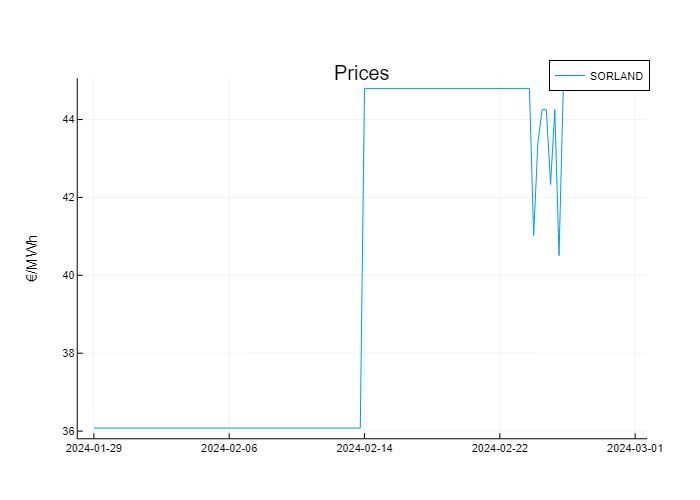

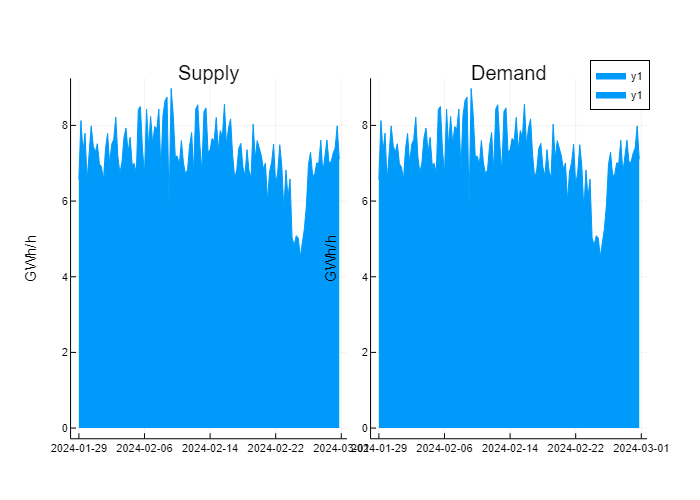

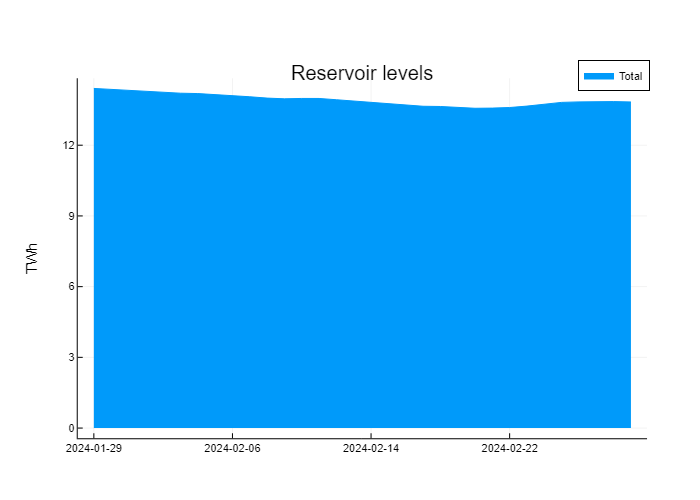

┌────────────────────────────────────────┬───────────────────┬─────────────────────────────────┬───────────────────┐
│                             Supplyname │ Yearly_supply_TWh │                      Demandname │ Yearly_demand_TWh │
│                                String? │          Float64? │                         String? │          Float64? │
├────────────────────────────────────────┼───────────────────┼─────────────────────────────────┼───────────────────┤
│          Plant_SORLAND_hydro_reservoir │           36.7721 │             Demand_SORLAND_BYGG │           14.8538 │
│                Plant_SORLAND_hydro_RoR │           13.6804 │        Transm_SORLAND->DANM-DK1 │           12.5196 │
│               Transm_TELEMARK->SORLAND │            7.2327 │              Transm_SORLAND->UK │            11.388 │
│         Fixed_EMPS4_wind_onshore_stock │           4.48969 │        Transm_SORLAND->TYSKLAND │           8.91056 │
│               Transm_DANM-DK1->SORLAND │          0.447081 │  

In [11]:
# Plot prices
idxwohub = findall(x -> !occursin("HUB", x), powerbalancenames) # remove hubs, not active in 2025 dataset
display(plot(x1, prices[:,idxwohub]*100, labels=reshape(powerbalancenames[idxwohub],1,length(powerbalancenames[idxwohub])), size=(800,500), title="Prices", ylabel="€/MWh"))

# # Plot supplies and demands
# maxdemsup = isempty(supplyvalues) ? maximum(demandvalues) : (isempty(demandvalues) ? maximum(supplyvalues) : max(maximum(demandvalues), maximum(supplyvalues)))
# supplychart = plot(x1, supplyvalues,labels=reshape(supplynames,1,length(supplynames)),title="Supply", ylabel = "GWh/h", ylims=(0,maxdemsup))
# demandchart = plot(x1, demandvalues,labels=reshape(demandnames,1,length(demandnames)),title="Demand", ylabel = "GWh/h", ylims=(0,maxdemsup))
sumsupplyvalues = sum(supplyvalues,dims=2)
sumdemandvalues = sum(demandvalues,dims=2)
maxdemsup = isempty(sumsupplyvalues) ? maximum(sumdemandvalues) : (isempty(sumdemandvalues) ? maximum(sumsupplyvalues) : max(maximum(sumdemandvalues), maximum(sumsupplyvalues)))
supplychart = areaplot(x1,sumsupplyvalues,title="Supply", ylabel = "GWh/h")
demandchart = areaplot(x1,sumdemandvalues,title="Demand", ylabel = "GWh/h")
display(plot([supplychart,demandchart]...,layout=(1,2),size=(800,500)))
# display(plot(supplychart,size=(800,500)))

# Plot storages
# display(areaplot(x2, hydrolevels1,labels=reshape(hydronames,1,length(hydronames)),size=(800,500),title="Reservoir levels", ylabel = "TWh")) #
display(areaplot(x2, dropdims(sum(hydrolevels,dims=2),dims=2),labels="Total",size=(800,500),title="Reservoir levels", ylabel = "TWh")) #

# display(areaplot(x1, dropdims(sum(batterylevels,dims=2),dims=2),labels="Total",size=(800,500),title="Short term storage levels", ylabel = "GWh")) #

# Plot list of yearly mean production and demand for each supply/demand TODO: split demand/supply and transmission
meandemand = dropdims(mean(demandvalues,dims=1),dims=1)
meanproduction = dropdims(mean(supplyvalues,dims=1),dims=1)
supplydf = sort(DataFrame(Supplyname = supplynames, Yearly_supply_TWh = meanproduction*8.76),[:Yearly_supply_TWh], rev = true)
demanddf = sort(DataFrame(Demandname = demandnames, Yearly_demand_TWh = meandemand*8.76),[:Yearly_demand_TWh], rev = true)
supplydf[!,:ID] = collect(1:length(supplynames))
demanddf[!,:ID] = collect(1:length(demandnames))
joineddf = select!(outerjoin(supplydf,demanddf;on=:ID),Not(:ID))
pretty_table(joineddf, show_subheader = true)

# Check that total supply equals total demand
pretty_table(combine(joineddf, [:Yearly_supply_TWh, :Yearly_demand_TWh] .=> sum∘skipmissing), show_subheader = true)

# Plot list of yearly income and cost for each supply/demand (only works if exogenprices are collected)
supplyrev = copy(supplyvalues)
for (i,supplybalancename) in enumerate(supplybalancenames)
    idx = findfirst(isequal(supplybalancename), powerbalancenames)
    supplyrev[:,i] .= supplyrev[:,i] .* prices[:,idx]
end
demandrev = copy(demandvalues)
for (i,demandbalancename) in enumerate(demandbalancenames)
    idx = findfirst(isequal(demandbalancename), powerbalancenames)
    demandrev[:,i] .= demandrev[:,i] .* prices[:,idx]
end
meandemandrev = dropdims(mean(demandrev,dims=1),dims=1)
meanproductionrev = dropdims(mean(supplyrev,dims=1),dims=1)
supplyrevdf = sort(DataFrame(Supplyname = supplynames, Yearly_rev_mill€ = meanproductionrev*8.76),[:Yearly_rev_mill€], rev = true)
demandrevdf = sort(DataFrame(Demandname = demandnames, Yearly_cost_mill€ = meandemandrev*8.76),[:Yearly_cost_mill€], rev = true)
supplyrevdf[!,:ID] = collect(1:length(supplynames))
demandrevdf[!,:ID] = collect(1:length(demandnames))
joinedrevdf = select!(outerjoin(supplyrevdf,demandrevdf;on=:ID),Not(:ID))
# pretty_table(joinedrevdf, show_subheader = true)

# Sum revenues and cost
pretty_table(combine(joinedrevdf, [:Yearly_rev_mill€, :Yearly_cost_mill€] .=> sum∘skipmissing), show_subheader = true)

# # Plot storagevalues for each reservoir and scenarios
# maxlongtermstorages = 40
# maxshorttermstorages = 40
# shortindex = x3
# medindex = x3[1:Int(skipfactor):Int(end-skipfactor)]
# numop = length(findall(sn -> occursin("Operative", sn), scenarionames))
# numscen = length(scenarionames) - numop
# j = 0
# k = 0
# for (i, storagename) in enumerate(storagenames)
#     if shorts[i]
#         j += 1
#         j > maxshorttermstorages && continue
#         storagevalues_ = storagevalues[:,:,:]
#         index = shortindex
#     else
#         k += 1
#         k > maxlongtermstorages && continue
#         storagevalues_ = storagevalues[1:Int(skipfactor):Int(end-skipfactor),:,:]
#         index = medindex
#     end
#     p = plot(index, storagevalues_[:,1:numscen,i] * -100, size=(800,500), title="Storagevalues scenario and operative for " * storagename, labels=reshape(scenarionames[1:numscen], 1, numscen), ylabel="€/MWh")
#     plot!(p, index, storagevalues_[:,numscen+1:end,i] * -100, labels=reshape(scenarionames[numscen+1:end], 1, numop), linewidth=5)
#     display(p)
# end